# Data processing

Get device info

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
!nvidia-smi

Fri May 26 11:46:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!nvidia-smi -L
!lscpu | grep 'Model name'
!lscpu | grep '^CPU(s)'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep 'Core(s) per socket'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'CPU MHz'
!awk 'NR==3 {printf "Available memory:\t\t %.fG\n",$2/1024^2}' /proc/meminfo
!df -h / | awk 'NR==2 {print "Available disk:\t\t\t "$4}'

GPU 0: Tesla T4 (UUID: GPU-8adcf319-a11d-9e65-1cb3-019a5dc4d498)
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
CPU(s):                          8
Thread(s) per core:              2
Core(s) per socket:              4
Socket(s):                       1
CPU MHz:                         2000.158
Available memory:		 50G
Available disk:			 144G


Connect to Google drive and import dataset

In [4]:
%%capture
from google.colab import drive
drive.mount('drive')

In [5]:
import os

if not os.path.exists('data'):
  !mkdir 'data'
  !tar -xzf 'drive/MyDrive/classification/food-101.tar.gz' -C 'data'

Import modules

In [6]:
import gc
from pathlib import Path

from fastai.data.all import *
from fastai.vision.all import *

Find timm model

Declare constants

In [7]:
IMAGE_DIR = 'data/food-101/images'
META_DIR = 'data/food-101/meta'
TRAIN_SET = open(Path(META_DIR + '/train.txt')).read().split('\n')[:-1]
TEST_SET = open(Path(META_DIR + '/test.txt')).read().split('\n')[:-1]
CLASSES = open(Path(META_DIR + '/classes.txt')).read().split('\n')[:-1]

In [8]:
MODEL_NAME = models.efficientnet_v2_l

LR = 1e-3
EPOCHS = 10
BATCH_SIZE = 64

CBS = SaveModelCallback()
METRICS = [error_rate, accuracy, top_k_accuracy]
SUGGEST_FUNC = (minimum, steep, valley, slide)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Dataloader function

In [9]:
item = (Resize(224))
batch = aug_transforms(size=224)

In [10]:
params = {'seed': 42, 'bs': BATCH_SIZE}

In [11]:
fnames = [f'{IMAGE_DIR}/{i}.jpg' for i in TRAIN_SET]
labels = [i.split('/')[0] for i in TRAIN_SET]

dls_train = ImageDataLoaders.from_lists(IMAGE_DIR, fnames, labels, 
                                        bs=BATCH_SIZE, seed=42,
                                        item_tfms=item, batch_tfms=batch,
                                        drop_last=False, device=DEVICE)

In [12]:
fnames = [f'{IMAGE_DIR}/{i}.jpg' for i in TEST_SET]
labels = [i.split('/')[0] for i in TEST_SET]

dls_test = ImageDataLoaders.from_lists(IMAGE_DIR, fnames, labels, 
                                       bs=BATCH_SIZE, seed=42, valid_pct=0,
                                       item_tfms=item, drop_last=False, 
                                       device=DEVICE)

In [13]:
print(f'train items: {dls_train.train.n}, train classes: {len(dls_train.train.vocab)}')
print(f'valid items: {dls_train.valid.n}, valid classes: {len(dls_train.valid.vocab)}')
print(f'test items: {dls_test.train.n}, test classes: {len(dls_test.train.vocab)}')

train items: 60600, train classes: 101
valid items: 15150, valid classes: 101
test items: 25250, test classes: 101


# Model training

Train model

In [14]:
%%capture
learn = vision_learner(dls_train, MODEL_NAME, n_out=101, metrics=METRICS, lr=LR, concat_pool=False)
if DEVICE == 'cuda:0':
  learn.cuda
else:
  learn.cpu

In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=0.001, m

In [16]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [CastToTensor]
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop

minimum: 0.00831763744354248
steep: 0.03981071710586548
valley: 0.0030199517495930195
slide: 0.005248074419796467



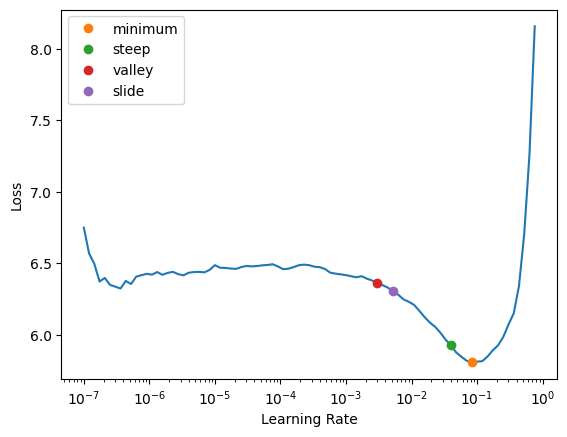

In [17]:
lrs = learn.lr_find(suggest_funcs=SUGGEST_FUNC)
print(f'minimum: {lrs.minimum}')
print(f'steep: {lrs.steep}')
print(f'valley: {lrs.valley}')
print(f'slide: {lrs.slide}\n')

In [18]:
learn.fine_tune(EPOCHS, lrs.valley)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,2.376725,1.632999,0.415908,0.584092,0.825875,05:15


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.671315,1.169929,0.301452,0.698548,0.893795,07:17
1,1.313384,0.902728,0.236568,0.763432,0.926535,07:17
2,1.059983,0.753982,0.198350,0.801650,0.943828,07:17
3,0.875024,0.674744,0.178812,0.821188,0.951749,07:17
4,0.768191,0.636085,0.165413,0.834587,0.957096,07:18
5,0.624453,0.595784,0.155314,0.844686,0.960396,07:16
6,0.573356,0.581591,0.148449,0.851551,0.961254,07:17
7,0.511305,0.571344,0.145941,0.854059,0.963102,07:18
8,0.444455,0.567066,0.142706,0.857294,0.962772,07:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.671315,1.169929,0.301452,0.698548,0.893795,07:17
1,1.313384,0.902728,0.236568,0.763432,0.926535,07:17
2,1.059983,0.753982,0.198350,0.801650,0.943828,07:17
3,0.875024,0.674744,0.178812,0.821188,0.951749,07:17
4,0.768191,0.636085,0.165413,0.834587,0.957096,07:18
5,0.624453,0.595784,0.155314,0.844686,0.960396,07:16
6,0.573356,0.581591,0.148449,0.851551,0.961254,07:17
7,0.511305,0.571344,0.145941,0.854059,0.963102,07:18
8,0.444455,0.567066,0.142706,0.857294,0.962772,07:18
9,0.441433,0.568168,0.143102,0.856898,0.962508,07:19


Evaluate model

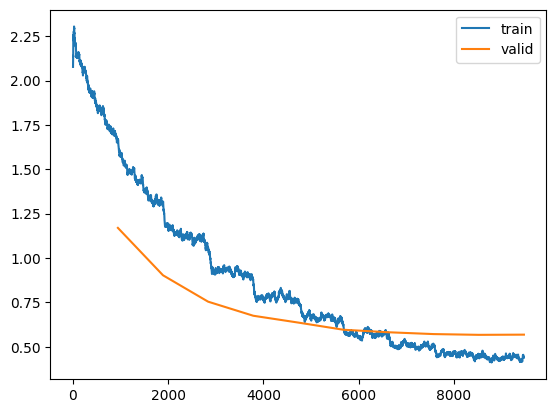

In [19]:
learn.recorder.plot_loss()

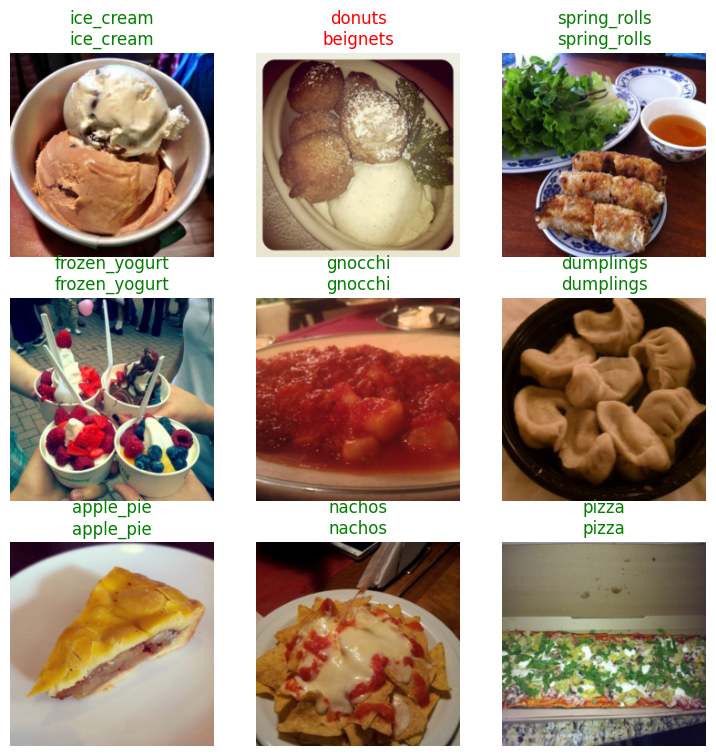

In [20]:
learn.show_results()

In [21]:
train_infer = '\t\t'.join([f'{i:.4f}' for i in learn.validate(0)])
valid_infer = '\t\t'.join([f'{i:.4f}' for i in learn.validate()])

In [31]:
print('\t\t'.join(['', 'Loss', 'Error', 'Top 1', 'Top 5']))
print(f'Train\t\t{train_infer}')
print(f'Valid\t\t{valid_infer}')

		Loss		Error		Top 1		Top 5
Train		0.2133		0.0607		0.9393		0.9917
Valid		0.5682		0.1431		0.8569		0.9625


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(101, 101))

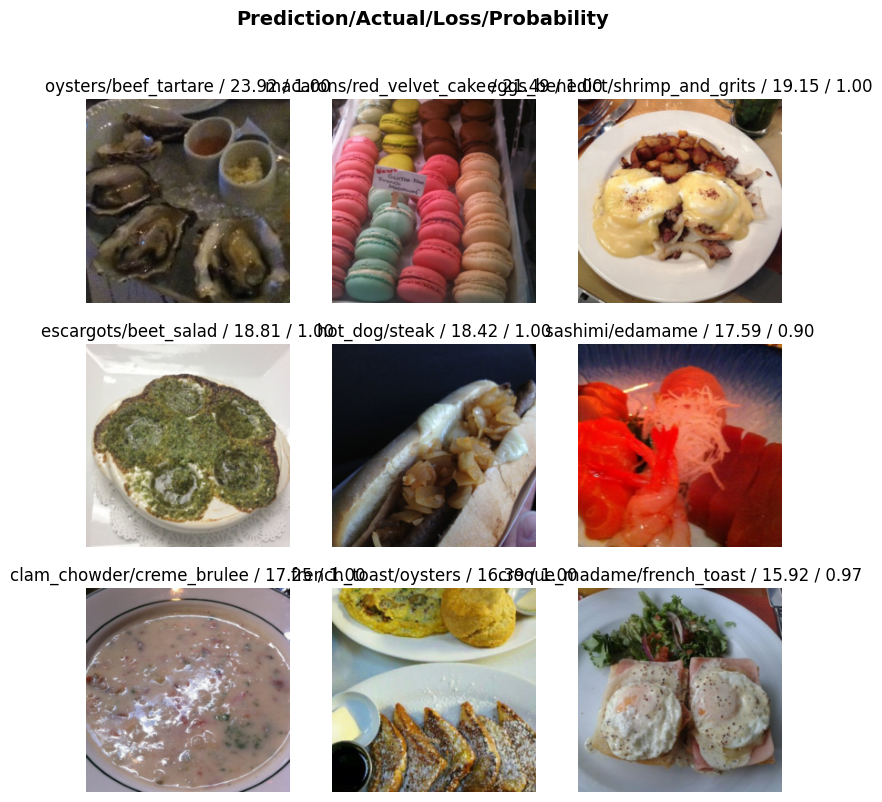

In [ ]:
interp.plot_top_losses(9)

In [ ]:
interp.most_confused()

[('filet_mignon', 'steak', 23),
 ('chocolate_mousse', 'chocolate_cake', 20),
 ('steak', 'filet_mignon', 20),
 ('apple_pie', 'bread_pudding', 17),
 ('beef_tartare', 'tuna_tartare', 14),
 ('prime_rib', 'steak', 14),
 ('chocolate_cake', 'chocolate_mousse', 13),
 ('donuts', 'beignets', 13),
 ('tuna_tartare', 'beef_tartare', 13),
 ('pork_chop', 'steak', 11),
 ('pork_chop', 'filet_mignon', 10),
 ('apple_pie', 'baklava', 9),
 ('bread_pudding', 'apple_pie', 9),
 ('ravioli', 'lasagna', 9),
 ('ceviche', 'tuna_tartare', 8),
 ('cheesecake', 'strawberry_shortcake', 8),
 ('shrimp_and_grits', 'gnocchi', 8),
 ('sushi', 'sashimi', 8),
 ('tiramisu', 'chocolate_mousse', 8),
 ('tuna_tartare', 'ceviche', 8),
 ('caprese_salad', 'beet_salad', 7),
 ('chocolate_cake', 'red_velvet_cake', 7),
 ('frozen_yogurt', 'ice_cream', 7),
 ('grilled_cheese_sandwich', 'garlic_bread', 7),
 ('onion_rings', 'fried_calamari', 7),
 ('pulled_pork_sandwich', 'hamburger', 7),
 ('ramen', 'pho', 7),
 ('steak', 'pork_chop', 7),
 ('bab

In [ ]:
interp.print_classification_report()

In [ ]:
fname = 'EfficientNetL2'
mpath = learn.save(fname)
!cp $mpath 'drive/MyDrive/'$fname'.pth'
learn.export(f'{fname}.pkl')
!cp $IMAGE_DIR'/'$fname'.pkl' 'drive/MyDrive/'$fname'.pkl'

In [ ]:
#Model: food-101-ResNet50-1e-57-55-v2-512
y_preds_TTA, y_TTA = learn.tta()

top_1_accuracy_TTA = accuracy(y_preds_TTA, y_TTA)
top_5_accuracy_TTA = top_k_accuracy(y_preds_TTA, y_TTA, k=5)

print('TTA: top_1_accuracy: ',top_1_accuracy_TTA )
print('TTA: top_5_accuracy: ',top_5_accuracy_TTA )

In [ ]:
# Import the necessary libraries
from sklearn.metrics import classification_report

preds, targets = learn.get_preds(dl=dls_test.train)

# Convert the predictions and targets to numpy arrays
preds = y_preds_TTA.numpy().argmax(axis=1)
targets = y_TTA.numpy()

# Print the classification report
print(classification_report(targets, preds))

In [30]:
learn.validate(0, dls_test.train)

(#4) [0.3771381974220276,0.10617821663618088,0.8938217759132385,0.9825742840766907]

# Feature extraction

Load saved model

In [ ]:
fname = f'new_v3_{MODEL_NAME}'
model_dir = f'{IMAGE_DIR}/models'
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
!cp 'drive/MyDrive/'$fname'.pth' $model_dir'/'$fname'.pth'
!cp 'drive/MyDrive/'$fname'.pth' '.'
!cp 'drive/MyDrive/'$fname'.pkl' '.'

In [ ]:
learner = load_learner(f'{fname}.pkl', DEVICE=='cpu').load(fname)

In [ ]:
learner.validate(0, dls_test.train)

(#4) [0.36627471446990967,0.10205940902233124,0.8979405760765076,0.9858613610267639]

In [ ]:
model = nn.Sequential(*list(learner.model.children()))[:-1]

In [ ]:
model

Sequential(
  (0): TimmBody(
    (model): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (0): BasicLayer(
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (mlp): Mlp(
     

In [ ]:
for param in model.parameters():
    param.requires_grad = False

Extract features

In [ ]:
BATCH_SIZE = 125

In [ ]:
fnames = [f'{IMAGE_DIR}/{i}.jpg' for i in TRAIN_SET]
labels = [i.split('/')[0] for i in TRAIN_SET]

dls_train = ImageDataLoaders.from_lists(IMAGE_DIR, fnames, labels, 
                                        bs=BATCH_SIZE, seed=42, valid_pct=0,
                                        item_tfms=item, batch_tfms=batch,
                                        drop_last=False, device=DEVICE)

In [ ]:
fnames = [f'{IMAGE_DIR}/{i}.jpg' for i in TEST_SET]
labels = [i.split('/')[0] for i in TEST_SET]

dls_test = ImageDataLoaders.from_lists(IMAGE_DIR, fnames, labels, 
                                       bs=BATCH_SIZE, seed=42, valid_pct=0,
                                       item_tfms=item, drop_last=False, 
                                       device=DEVICE)

In [ ]:
def feature_extractor(dl, m, num_batches):
  features, labels = [], []
  count = 1
  for x, y in iter(dl):
    if count % 100 == 0 or count == num_batches:
      print(count)
    out = m(x)
    features.extend(out.cpu().detach().numpy())
    labels.extend(y.cpu().detach().numpy())
    count += 1
  return [features, np.array(labels)]

In [ ]:
features = feature_extractor(dls_train.train, model, len(dls_train.train))
x_train = features[0]
y_train = features[1]

100
200
300
400
500
600
606


In [ ]:
features = feature_extractor(dls_test.train, model, len(dls_test.train)) 
x_test = features[0]
y_test = features[1]

100
200
202


In [ ]:
print(len(x_train), len(y_train), len(x_test), len(y_test))

75750 75750 25250 25250


# Classification

Dask client

In [ ]:
%%capture
%pip install dask-ml
%pip install dask-ml[complete]

In [ ]:
from dask.distributed import Client, progress

In [ ]:
client = Client()

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:40351
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43639'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33945'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42669'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36887'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:37173', name: 3, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:37173
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:35674
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:46757', name: 2, status: 

In [ ]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 51.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40351,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 51.00 GiB
Comm: tcp://127.0.0.1:37859,Total threads: 2
Dashboard: http://127.0.0.1:43699/status,Memory: 12.75 GiB
Nanny: tcp://127.0.0.1:43639,


Create Dask array

In [ ]:
import dask.array as da

In [ ]:
da_x_train = da.from_array(x_train, chunks=(7575, 1024))
da_y_train = da.from_array(y_train, chunks=(7575,))
da_x_test = da.from_array(x_test, chunks=(2525, 1024))
da_y_test = da.from_array(y_test, chunks=(2525,))

ValueError: ignored

SVM classifier

In [ ]:
import joblib

from dask_ml.model_selection import GridSearchCV
from dask_ml.metrics import accuracy_score
from dask_ml.wrappers import ParallelPostFit
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC

In [ ]:
C = [1, 10, 20, 100]

In [ ]:
for x in C:
  print(f'SVC with kernel=rbf and C={x}')
  svc = SVC(C=x)
  svc.fit(da_x_train, da_y_train)
  y_pred = svc.predict(da_x_test)
  print(f'accuracy: {str(accuracy_score(da_y_test, y_pred))}\n')

In [ ]:
for x in C:
  print(f'SVC with kernel=linear and C={x}')
  svc = SVC(C=x, kernel='linear')
  svc.fit(da_x_train, da_y_train)
  y_pred = svc.predict(da_x_test)
  print(f'accuracy: {str(accuracy_score(da_y_test, y_pred))}\n')